In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os

Função de carregar dados

In [ ]:
NUM_CLIENTS = 10

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dados(train_data,test_data):
  train_data = pd.read_csv(train_data)
  val_data = pd.read_csv(test_data)

  X_train = train_data.drop(['hysteresis', 'joule'], axis=1)
  y_train = train_data[['hysteresis', 'joule']]

  X_val = val_data.drop(['hysteresis', 'joule'], axis=1)
  y_val = val_data[['hysteresis', 'joule']]

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)

  X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

  X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
  y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

  return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor



Função Matplotlib


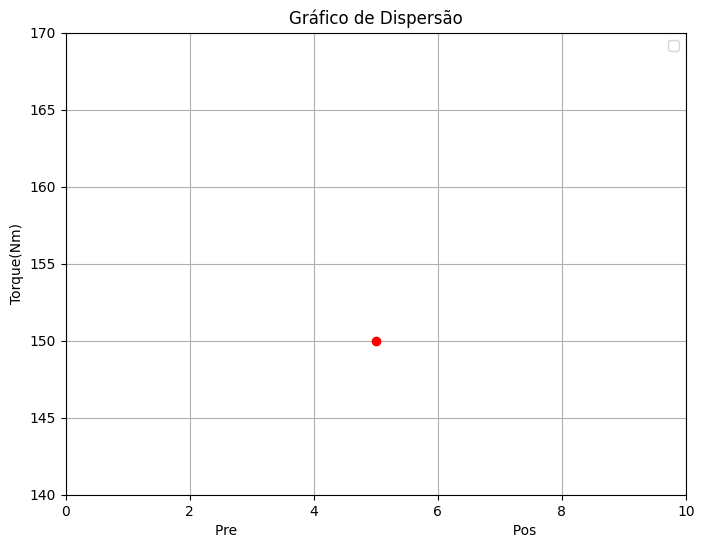

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Torque(N*m)')
    plt.ylabel('Pre---------Pos')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt


Definindo rede neural densa

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


Carregando dados "2D"

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs (1)/dataset_for_iron_losses_of_IPMSMs/Nabla'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
print(input_size)
output_size = y_train_tensor.shape[1]
print(output_size)
model = NeuralNetwork(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)


11
2


In [ ]:

def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer):
  criterion = nn.MSELoss()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(X_train_tensor)
      loss = criterion(outputs, y_train_tensor)
      loss.backward()
      optimizer.step()

      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


def test(model):
  model.eval()
  criterion = nn.MSELoss()
  with torch.no_grad():
      predicted = model(X_val_tensor)
      test_loss = criterion(predicted, y_val_tensor)
      print(f'Test Loss: {test_loss.item():.4f}')
  return predicted



Treinando e salvando o modelo com dados "2D"

In [ ]:
train(model,2000,optimizer)

modeltosave = {'state_dict': model.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave)




Epoch [100/2000], Loss: 0.0436
Epoch [200/2000], Loss: 0.0222
Epoch [300/2000], Loss: 0.0148
Epoch [400/2000], Loss: 0.0112
Epoch [500/2000], Loss: 0.0093
Epoch [600/2000], Loss: 0.0082
Epoch [700/2000], Loss: 0.0073
Epoch [800/2000], Loss: 0.0067
Epoch [900/2000], Loss: 0.0063
Epoch [1000/2000], Loss: 0.0059
Epoch [1100/2000], Loss: 0.0056
Epoch [1200/2000], Loss: 0.0053
Epoch [1300/2000], Loss: 0.0050
Epoch [1400/2000], Loss: 0.0048
Epoch [1500/2000], Loss: 0.0046
Epoch [1600/2000], Loss: 0.0045
Epoch [1700/2000], Loss: 0.0043
Epoch [1800/2000], Loss: 0.0042
Epoch [1900/2000], Loss: 0.0041
Epoch [2000/2000], Loss: 0.0039
salvando modelo...


Testando o modelo

Test Loss: 0.0050


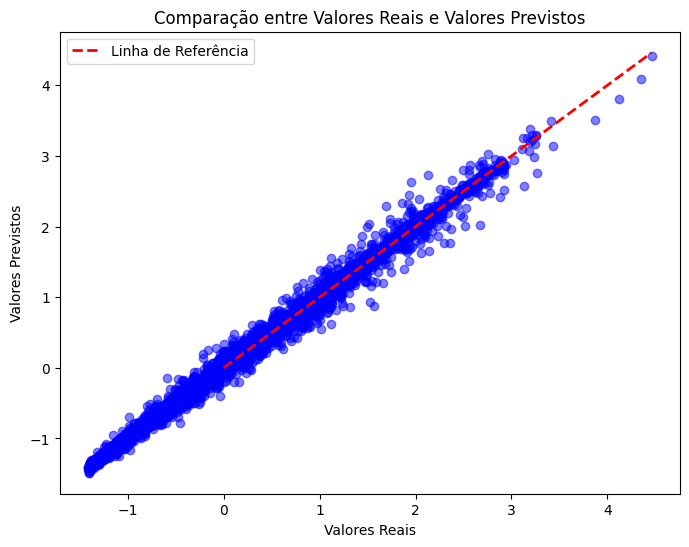

In [ ]:
plot_comparacao(y_val_tensor,test(model))

Carregando o modelo pre treinado

In [ ]:
new_model, new_optimizer = load_model("Saved_Model.pth",NeuralNetwork,input_size,output_size)

Carregando modelo...


Carregando dados do dataset "V"

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs (1)/dataset_for_iron_losses_of_IPMSMs/Nabla'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = carregar_dados('dados_de_treino.csv','dados_de_teste.csv')
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]


Alterando a entrada do modelo principal

Test Loss: 1.1169


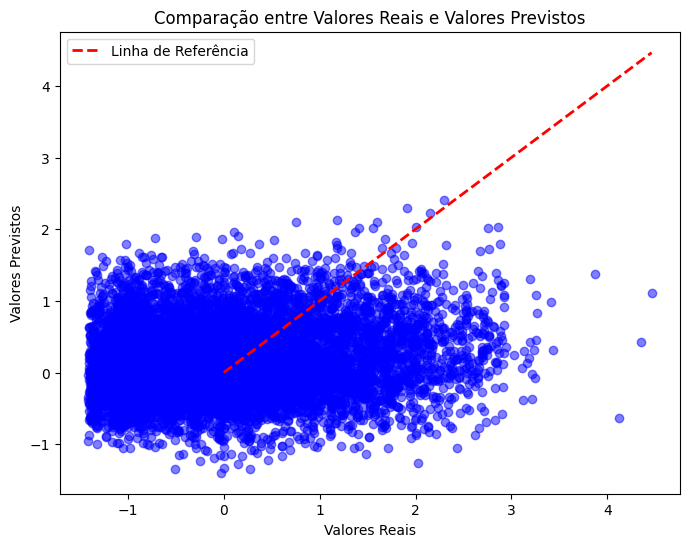

In [ ]:
new_model.fc1 = nn.Linear(input_size, 64)
plot_comparacao(y_val_tensor,test(new_model))

In [ ]:
train(new_model,2000,new_optimizer)

Epoch [100/2000], Loss: 0.0038
Epoch [200/2000], Loss: 0.0038
Epoch [300/2000], Loss: 0.0037
Epoch [400/2000], Loss: 0.0036
Epoch [500/2000], Loss: 0.0035
Epoch [600/2000], Loss: 0.0035
Epoch [700/2000], Loss: 0.0034
Epoch [800/2000], Loss: 0.0035
Epoch [900/2000], Loss: 0.0033
Epoch [1000/2000], Loss: 0.0032
Epoch [1100/2000], Loss: 0.0032
Epoch [1200/2000], Loss: 0.0031
Epoch [1300/2000], Loss: 0.0031
Epoch [1400/2000], Loss: 0.0030
Epoch [1500/2000], Loss: 0.0030
Epoch [1600/2000], Loss: 0.0030
Epoch [1700/2000], Loss: 0.0029
Epoch [1800/2000], Loss: 0.0029
Epoch [1900/2000], Loss: 0.0028
Epoch [2000/2000], Loss: 0.0028


Test Loss: 0.0039


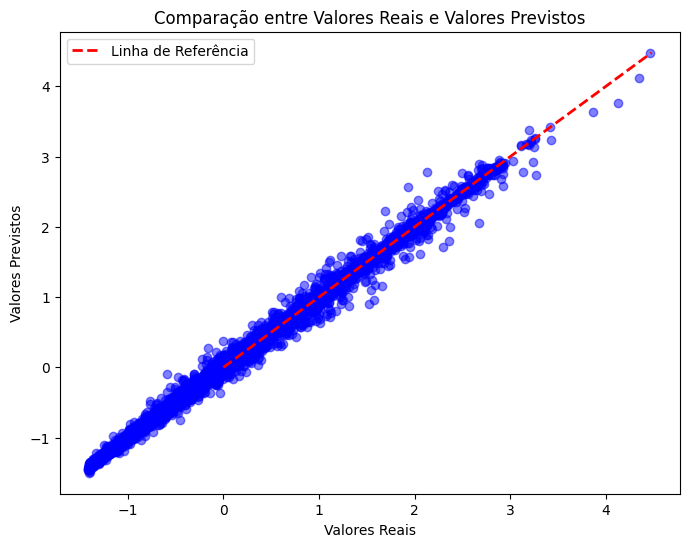

In [ ]:
plot_comparacao(y_val_tensor,test(new_model))